Analyze the Google drive feedback (exported as tsv in `data/feedback.tsv`) that are embeded at the end of tutorials

In [1]:
!type python

python is /Users/bebatut/miniconda3/envs/galaxy-training-material-stats/bin/python


In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from pprint import pprint

In [3]:
url = 'https://docs.google.com/spreadsheets/d/1NfZhi5Jav7kl9zFCkeb7rIC2F8xW1isruv1TeO4WpNI/export?format=tsv'

# Load the feedback

In [4]:
df = pd.read_csv(url, sep='\t')
# remove last column
df = df.drop(['Make feedback confidential?'], axis=1)
# rename column
df = df.rename(columns = {'Timestamp': 'timestamp',
    'How much did you like this tutorial?': 'note',
    'What did you like?': 'pro',
    'What could be improved?': 'con',
    'Tutorial': 'tutorial_topic'})
# extract topic from tutorial name
new = df.tutorial_topic.str[::-1].str.split('(', n = 1, expand = True)
df["tutorial"]= new[1].str[::-1].str[:-1]
df["topic"]= new[0].str[::-1].str[:-1]
df = df.drop(columns =["tutorial_topic"])
# remove rows with NaN on note, pro and con
df = df.dropna(subset=['note', 'pro', 'con'], how='all')
# replace NaN in note by 0
df = df.fillna(value={'note': 0})
# format note to integer
df.note = df.note.astype(int)
# format pro and con to string
df.pro = df.pro.astype(str)
df.con = df.con.astype(str)
# format timestamp to remove hour
df.timestamp = df.timestamp.str.split(' ', n = 1, expand = True)[0]
# number of rows
len(df)

600

In [5]:
df.head()

,timestamp,note,pro,con,tutorial,topic
0,09/09/2018,4,nan,the clear instruction pattern,A short introduction to Galaxy,Introduction to Galaxy Analyses
1,11/09/2018,5,very detailed,nan,A short introduction to Galaxy,Introduction to Galaxy Analyses
2,14/09/2018,5,"very detailed and easy to follow, even for a c...",nan,Galaxy 101,Introduction to Galaxy Analyses
3,15/09/2018,5,"very detailed and easy to follow, thank you",nan,Introduction to Genomics and Galaxy,Introduction to Galaxy Analyses
4,15/09/2018,5,That all the tools had helpful explanations,If there was a guide to say which tool to use ...,Galaxy 101,Introduction to Galaxy Analyses


In [6]:
# change topic for some tutorials
df.loc[df.tutorial == 'Formation of the Super-Structures on the Inactive X', 'topic'] = 'Epigenetics'
df.loc[df.tutorial == 'Identification of the binding sites of the Estrogen receptor', 'topic'] = 'Epigenetics'
df.loc[df.tutorial == 'Identification of the binding sites of the T-cell acute lymphocytic leukemia protein 1 (TAL1)', 'topic'] = 'Epigenetics'
df.loc[df.tutorial == 'RAD-Seq Reference-based data analysis', 'topic']
df.loc[df.tutorial == 'RAD-Seq de-novo data analysis', 'topic']
df.loc[df.tutorial == 'RAD-Seq to construct genetic maps', 'topic']

Series([], Name: topic, dtype: object)

# Aggregate the feedbacks and notes

In [7]:
def get_notes(df, name):
    '''Aggregage the notes
    
    :df: dataframe with all feedbacks
    
    :return: dataframe object with aggregated notes
    '''
    notes = df.note.value_counts(sort=False).to_frame()
    notes = notes.rename(columns= {'note': name})
    return notes

In [8]:
notes = get_notes(df, 'All topics')

In [9]:
def get_notes(df, name):
    '''Aggregage the notes
    
    :df: dataframe with all feedbacks
    
    :return: dataframe object with aggregated notes
    '''
    notes = df.note.value_counts(sort=False).to_frame()
    notes = notes.rename(columns= {'note': name})
    return notes


def get_topic_df(grouped_by_topic, topic, notes):
    '''Extract the dataframe for a topic and plot note histogram
    
    :grouped_by_topic: groupby object grouping by topic
    :topic: topic to extract
    
    :return: dataframe object for the topic
    '''
    topic_df = grouped_by_topic.get_group(topic)
    topic_df = topic_df.drop('topic', 1)
    
    notes = pd.concat([notes, get_notes(topic_df, topic)], axis=1)
    return topic_df, notes


def extract_tutorial_feedbacks(topic_df, topic_name):
    '''Extract pro/con per tutorial for a topic and 
    write them in a file
    
    :topic_df: dataframe object for the topic
    :topic_name: name for the topic, name for the file
    '''
    grouped_by_tuto = topic_df.groupby(by="tutorial")
    with open('../results/%s.md' % topic_name, 'w') as f:
        for tuto, group in grouped_by_tuto:
            # get groups
            tuto_df = grouped_by_tuto.get_group(tuto)
            pros = []
            cons = []
            # get pros/cons
            for index, row in tuto_df.iterrows():
                if row['pro'] != 'nan':
                    pros.append("%s (*%s*)" % (row['pro'], row['timestamp']))
                if row['con'] != 'nan':
                    cons.append("%s (*%s*)" % (row['con'], row['timestamp']))
            # write in report file
            f.write("- **%s**\n" % tuto)
            if len(pros) > 0:
                f.write("  - Pro:\n    - ")
                f.write("\n    - ".join(pros))
            if len(cons) > 0:
                f.write("\n  - Con:\n    - ")
                f.write("\n    - ".join(cons))
            f.write("\n\n")

In [10]:
grouped_by_topic = df.groupby(by="topic")
for topic in grouped_by_topic.groups:
    print(topic)
    topic_df, notes = get_topic_df(grouped_by_topic, topic, notes)
    topic_name = topic.lower().replace(' ', '-')
    extract_tutorial_feedbacks(topic_df, topic_name)

Assembly
Contributing to the Galaxy Training Material
Data Manipulation
Development in Galaxy
Ecology
Epigenetics
Galaxy Server administration
Genome Annotation
Imaging
Introduction to Galaxy Analyses
Metabolomics
Metagenomics
Proteomics
Sequence analysis
Statistics and machine learning
Teaching and Hosting Galaxy training
Transcriptomics
User Interface and Features
Variant Analysis


Details (pros/cons) for each tutorials are available: https://github.com/bebatut/galaxy-training-material-stats/tree/master/results

# Notes

In [11]:
def plot_note_histogram(s, title):
    s.plot(kind='barh', color='DarkOrange', ylim=(0,5), title=title)
    plt.show()

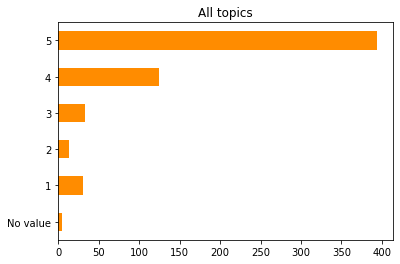

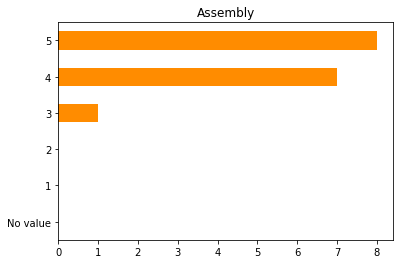

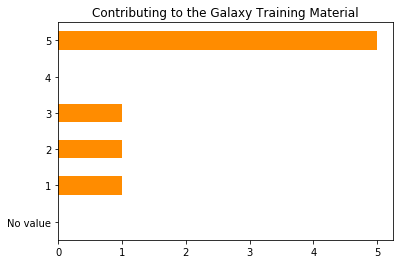

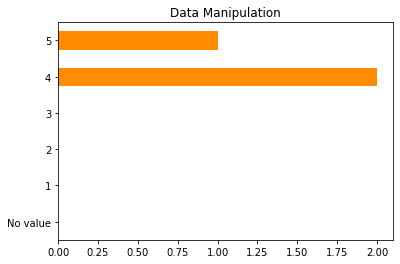

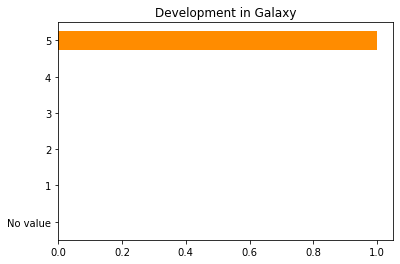

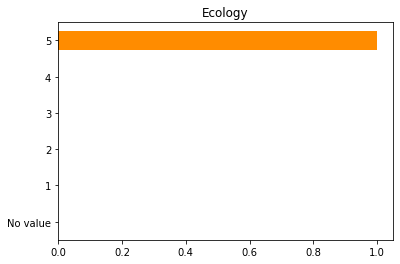

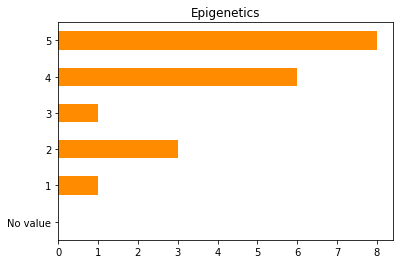

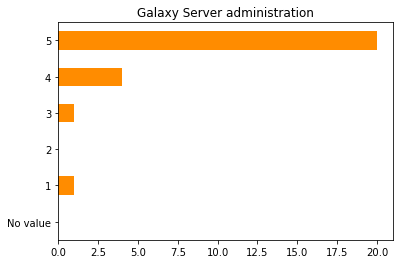

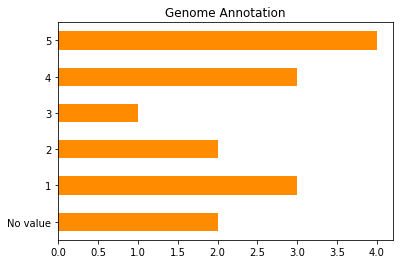

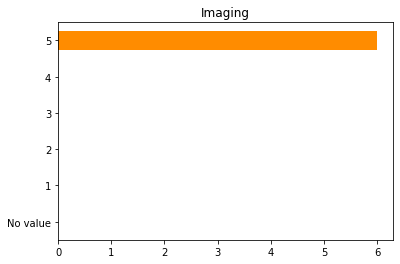

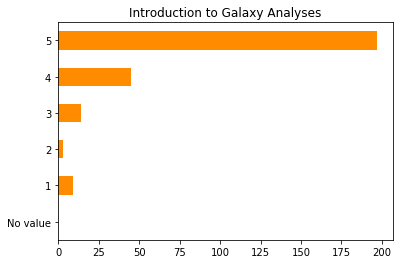

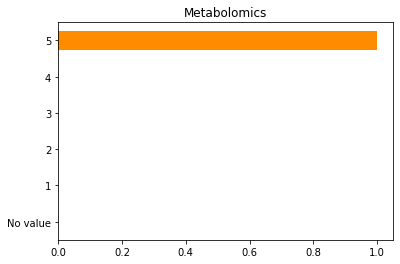

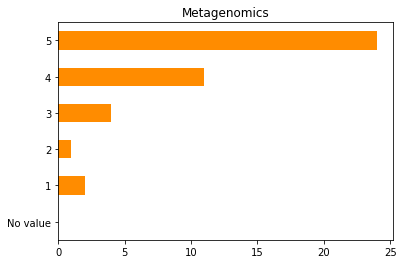

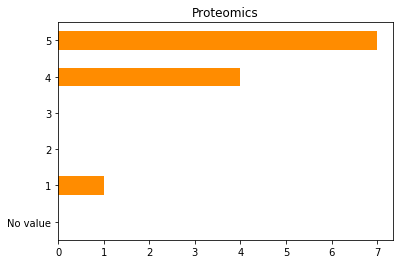

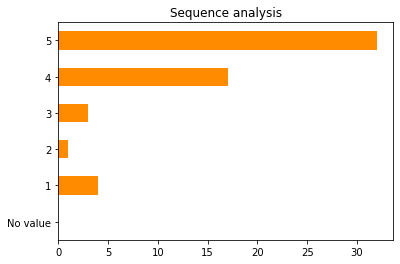

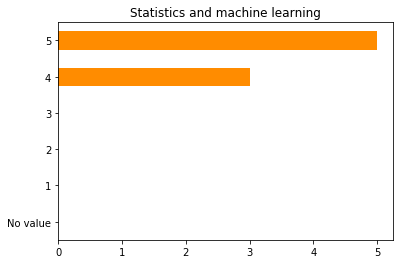

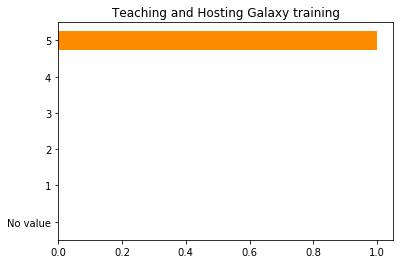

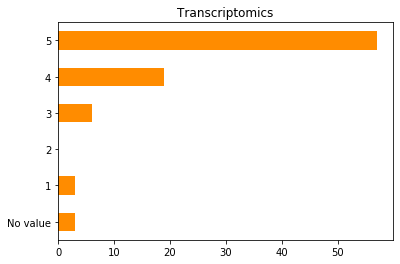

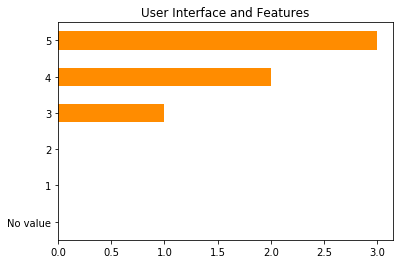

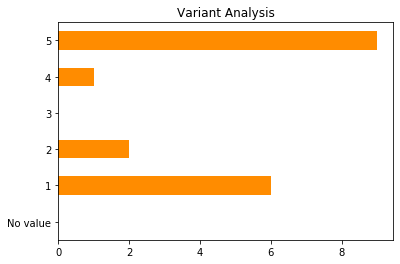

In [12]:
notes = notes.fillna(0.0).astype(int)
notes = notes.rename(index = {0: 'No value'})
for col in notes.columns:
    plot_note_histogram(notes[col], col)